# Generalization

### Can the Network Fit Random Labels

In [87]:
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable

PROJECT_PATH = "files/"
torch.manual_seed(1)

In [88]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, transform=transform)

print(f"Training set size: {len(mnist_train)}")
print(f"Test set size: {len(mnist_test)}")

# Randomize training labels
mnist_train.targets = torch.tensor(np.random.randint(0, 10, (len(mnist_train),)))

# Create data loaders
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

Training set size: 60000
Test set size: 10000


In [89]:
# Model Definition
class RandomizedMNISTNet(nn.Module):
    def __init__(self):
        super(RandomizedMNISTNet, self).__init__()
        self.fc1 = nn.Linear(784, 500)
        self.fc2 = nn.Linear(500, 50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [90]:
# Training & Testing Functions (alternate dev style)
def train_model(model, optimizer, criterion, epoch, data_loader, log_interval):
    model.train()
    total_samples = 0
    total_correct = 0

    for batch_idx, (inputs, targets) in enumerate(data_loader):
        inputs, targets = Variable(inputs), Variable(targets)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        _, predicted_labels = torch.max(outputs.data, 1)
        total_samples += targets.size(0)
        total_correct += (predicted_labels == targets).sum().item()

        if (batch_idx + 1) % log_interval == 0:
            print(f"Epoch {epoch} | Batch {batch_idx+1}/{len(data_loader)} | Loss: {loss.item():.4f}")

    train_accuracy = (total_correct / total_samples) * 100.0
    return loss.item(), round(train_accuracy, 2)


def test_model(model, criterion, data_loader):
    model.eval()
    total_samples = 0
    total_correct = 0
    accumulated_loss = 0
    num_batches = 0

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = Variable(inputs), Variable(targets)
            outputs = model(inputs)
            accumulated_loss += criterion(outputs, targets).item()
            _, predicted_labels = torch.max(outputs.data, 1)
            total_samples += targets.size(0)
            total_correct += (predicted_labels == targets).sum().item()
            num_batches += 1

    avg_loss = accumulated_loss / num_batches
    test_accuracy = (total_correct / total_samples) * 100.0
    print(f"Test Accuracy: {test_accuracy:.2f}% | Test Loss: {avg_loss:.4f}")
    return test_accuracy, avg_loss


In [91]:
model = RandomizedMNISTNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters in the model: {total_params}")

num_epochs = 50
log_interval = 300
train_losses = []
test_losses = []
epochs_list = []

for epoch in range(1, num_epochs + 1):
    epochs_list.append(epoch)
    train_loss, train_acc = train_model(model, optimizer, criterion, epoch, train_loader, log_interval)
    train_losses.append(train_loss)
    test_acc, test_loss = test_model(model, criterion, test_loader)
    test_losses.append(test_loss)

Total parameters in the model: 418060
Epoch 1 | Batch 300/600 | Loss: 2.2996
Epoch 1 | Batch 600/600 | Loss: 2.2993
Test Accuracy: 12.11% | Test Loss: 2.3028
Epoch 2 | Batch 300/600 | Loss: 2.3032
Epoch 2 | Batch 600/600 | Loss: 2.3017
Test Accuracy: 11.45% | Test Loss: 2.3052
Epoch 3 | Batch 300/600 | Loss: 2.2979
Epoch 3 | Batch 600/600 | Loss: 2.2999
Test Accuracy: 12.33% | Test Loss: 2.3081
Epoch 4 | Batch 300/600 | Loss: 2.3084
Epoch 4 | Batch 600/600 | Loss: 2.3018
Test Accuracy: 12.34% | Test Loss: 2.2966
Epoch 5 | Batch 300/600 | Loss: 2.2676
Epoch 5 | Batch 600/600 | Loss: 2.2950
Test Accuracy: 12.54% | Test Loss: 2.2950
Epoch 6 | Batch 300/600 | Loss: 2.2803
Epoch 6 | Batch 600/600 | Loss: 2.3108
Test Accuracy: 12.88% | Test Loss: 2.2848
Epoch 7 | Batch 300/600 | Loss: 2.2803
Epoch 7 | Batch 600/600 | Loss: 2.2692
Test Accuracy: 12.21% | Test Loss: 2.3022
Epoch 8 | Batch 300/600 | Loss: 2.2654
Epoch 8 | Batch 600/600 | Loss: 2.2921
Test Accuracy: 9.94% | Test Loss: 2.3385
Epo

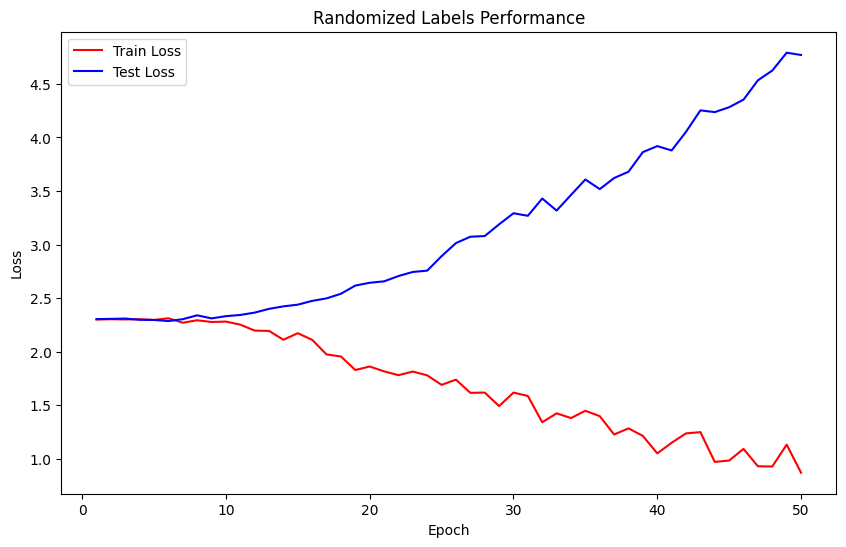

In [92]:
plt.figure(figsize=(10, 6))
plt.plot(epochs_list, train_losses, color="red", label="Train Loss")
plt.plot(epochs_list, test_losses, color="blue", label="Test Loss")
plt.legend(loc="best")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Randomized Labels Performance", color="black")
plt.savefig(f"{PROJECT_PATH}random.png", dpi=300, bbox_inches="tight")
plt.show()

### Number of parameters v.s. Generalization


In [93]:
# Constants
DATA_ROOT = './data'
BATCH_SIZE_TRAIN = 600
BATCH_SIZE_TEST = 100
INPUT_SIZE = 784
MAX_EPOCHS = 15
LEARNING_RATE = 0.0005
NUM_EPOCHS = 10

# Data loading
transform = torchvision.transforms.ToTensor()
mnist_train = torchvision.datasets.MNIST(root=DATA_ROOT, train=True, transform=transform, download=True)
mnist_test = torchvision.datasets.MNIST(root=DATA_ROOT, train=False, transform=transform)

print(f"Training set size: {len(mnist_train)}")
print(f"Test set size: {len(mnist_test)}")

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=BATCH_SIZE_TEST, shuffle=False)

print(f"Number of batches in train_loader: {len(train_loader)}")

Training set size: 60000
Test set size: 10000
Number of batches in train_loader: 100


In [94]:
# Model definitions
class BaseModel(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(INPUT_SIZE, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 10)

    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class Model1(BaseModel):
    def __init__(self):
        super().__init__(50)

class Model2(BaseModel):
    def __init__(self):
        super().__init__(100)

class Model3(BaseModel):
    def __init__(self):
        super().__init__(250)

class Model4(BaseModel):
    def __init__(self):
        super().__init__(500)

class Model5(BaseModel):
    def __init__(self):
        super().__init__(550)

class Model6(BaseModel):
    def __init__(self):
        super().__init__(750)

class Model7(BaseModel):
    def __init__(self):
        super().__init__(1000)

class Model8(BaseModel):
    def __init__(self):
        super().__init__(1050)

class Model9(BaseModel):
    def __init__(self):
        super().__init__(1500)

class Model10(BaseModel):
    def __init__(self):
        super().__init__(2000)

In [95]:
# Training & Testing Functions
def train_model(model, num_epochs):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    
    train_losses = []
    train_accuracies = []
    epoch_avg_losses = []
    train_epochs = []

    epoch = 0
    not_converged = True

    while not_converged:
        epoch += 1
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (images, labels) in enumerate(train_loader):
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if (i + 1) % 100 == 0:
                accuracy = 100 * correct / total
                print(f'Epoch [{epoch}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%', end='\r', flush=True)
                train_epochs.append(epoch)
                train_losses.append(loss.item())
                train_accuracies.append(accuracy)

                if epoch == num_epochs:
                    print("Max Epoch Reached")
                    not_converged = False
                elif (epoch > 5) and (train_losses[-1] < 0.001):
                    if abs(train_losses[-3] - train_losses[-2]) < 1e-5 and abs(train_losses[-2] - train_losses[-1]) < 1e-5:
                        print(f"Convergence reached for loss: {train_losses[-1]:.6f}")
                        not_converged = False

        epoch_avg_loss = running_loss / len(train_loader)
        epoch_avg_losses.append(epoch_avg_loss)
        print(f'For epoch {epoch} AVG_LOSS: {epoch_avg_loss:.4f}')

    return train_epochs, train_losses, train_accuracies, epoch_avg_losses

def test_model(model):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    correct = 0
    total = 0
    test_loss = 0
    count = 0

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            count += 1

    accuracy = 100 * correct / total
    avg_loss = test_loss / count
    print(f'Accuracy of the network:{model.__class__.__name__} on the test images: {accuracy:.2f}% & loss of the network:{avg_loss:.4f}')
    return accuracy, avg_loss

In [96]:
models = [Model1, Model2, Model3, Model4, Model5, Model6, Model7, Model8, Model9, Model10]
results = {}

for ModelClass in models:
    model = ModelClass()
    model_name = model.__class__.__name__
    
    num_params = sum(p.numel() for p in model.parameters())
    print(f'Total no of parameters in {model_name}: {num_params}')
    
    train_epochs, train_losses, train_accuracies, epoch_avg_losses = train_model(model, NUM_EPOCHS)
    test_accuracy, test_loss = test_model(model)
    
    results[model_name] = {
        'train_epochs': train_epochs,
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'epoch_avg_losses': epoch_avg_losses,
        'test_accuracy': test_accuracy,
        'test_loss': test_loss,
        'num_params': num_params
    }

Total no of parameters in Model1: 39760
For epoch 1 AVG_LOSS: 1.3581, Loss: 0.6576, Accuracy: 71.51%
For epoch 2 AVG_LOSS: 0.5281, Loss: 0.4067, Accuracy: 87.56%
For epoch 3 AVG_LOSS: 0.3821, Loss: 0.3191, Accuracy: 89.98%
For epoch 4 AVG_LOSS: 0.3266, Loss: 0.2775, Accuracy: 91.08%
For epoch 5 AVG_LOSS: 0.2951, Loss: 0.2398, Accuracy: 91.84%
For epoch 6 AVG_LOSS: 0.2728, Loss: 0.2900, Accuracy: 92.41%
For epoch 7 AVG_LOSS: 0.2543, Loss: 0.2458, Accuracy: 92.92%
For epoch 8 AVG_LOSS: 0.2388, Loss: 0.1923, Accuracy: 93.31%
For epoch 9 AVG_LOSS: 0.2248, Loss: 0.2180, Accuracy: 93.77%
Max Epoch Reachedep [100/100], Loss: 0.1849, Accuracy: 94.06%
For epoch 10 AVG_LOSS: 0.2127
Accuracy of the network:Model1 on the test images: 93.94% & loss of the network:0.2084
Total no of parameters in Model2: 79510
For epoch 1 AVG_LOSS: 1.1640, Loss: 0.4543, Accuracy: 75.81%
For epoch 2 AVG_LOSS: 0.4229, Loss: 0.3655, Accuracy: 89.13%
For epoch 3 AVG_LOSS: 0.3212, Loss: 0.2638, Accuracy: 91.22%
For epoch

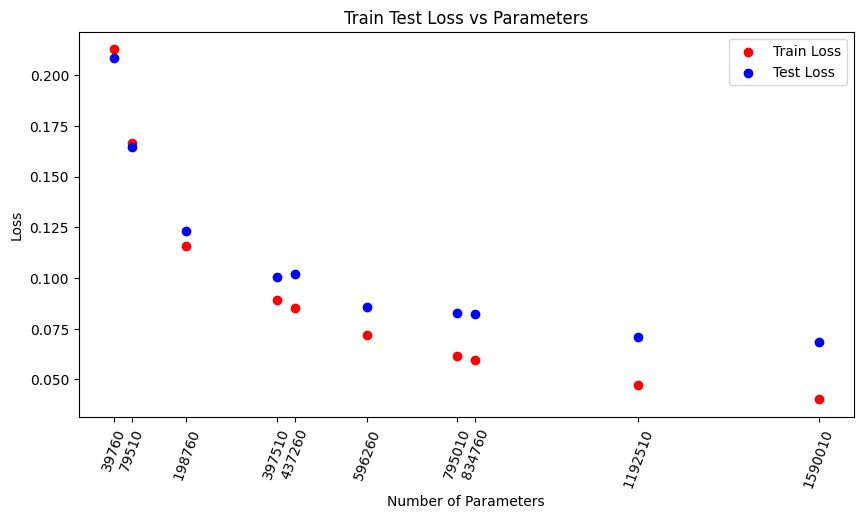

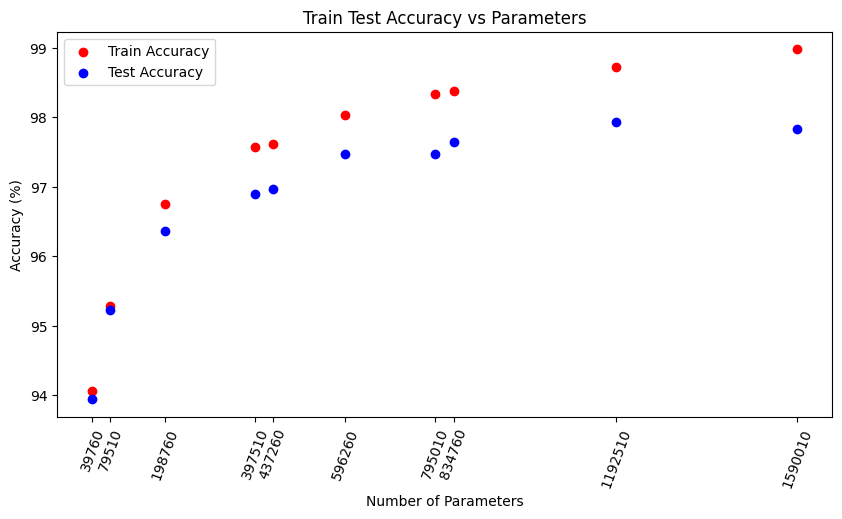

In [97]:
# Plotting
def plot_results(x_data, y_data1, y_data2, xlabel, ylabel, title, legend, filename):
    f = plt.figure()
    f.set_figwidth(10)
    f.set_figheight(5)
    plt.scatter(x_data, y_data1, color="red")
    plt.scatter(x_data, y_data2, color="blue")
    plt.xticks(x_data, x_data, rotation=70)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(legend)
    plt.title(title)
    plt.savefig(f"{PROJECT_PATH}{filename}", format='png', dpi=700, bbox_inches='tight')
    plt.show()

model_params = [results[f'Model{i}']['num_params'] for i in range(1, 11)]
train_losses = [min(results[f'Model{i}']['epoch_avg_losses']) for i in range(1, 11)]
test_losses = [results[f'Model{i}']['test_loss'] for i in range(1, 11)]
train_accuracies = [max(results[f'Model{i}']['train_accuracies']) for i in range(1, 11)]
test_accuracies = [results[f'Model{i}']['test_accuracy'] for i in range(1, 11)]

plot_results(model_params, train_losses, test_losses, 'Number of Parameters', 'Loss', 'Train Test Loss vs Parameters',['Train Loss', 'Test Loss'], 'loss.png')
plot_results(model_params, train_accuracies, test_accuracies,'Number of Parameters', 'Accuracy (%)', 'Train Test Accuracy vs Parameters',['Train Accuracy', 'Test Accuracy'], 'acc.png')

### Flatness vs Generalization

#### Part-1

In [98]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

def create_data_loader(dataset, batch_size, shuffle):
    return torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle)

In [99]:
def train_model(model, epochs, batch_size, update_interval):
    model.train()
    train_loader = create_data_loader(mnist_test, batch_size, True)
    num_batches = len(train_loader)
    
    losses_per_epoch = []
    accuracies_per_epoch = []
    losses_all = []
    accuracies_all = []
    
    for current_epoch in range(1, epochs + 1):
        correct_count = 0
        total_count = 0
        epoch_loss_total = 0
        
        for batch_idx, (batch_images, batch_labels) in enumerate(train_loader):
            batch_images, batch_labels = Variable(batch_images), Variable(batch_labels)
            optimizer.zero_grad()
            model_outputs = model(batch_images)
            batch_loss = criterion(model_outputs, batch_labels)
            batch_loss.backward()
            optimizer.step()
            
            _, predicted_labels = torch.max(model_outputs.data, 1)
            total_count += batch_labels.size(0)
            correct_count += (predicted_labels == batch_labels).sum().item()
            batch_accuracy = 100.0 * correct_count / total_count
            
            epoch_loss_total += batch_loss.item()
            losses_all.append(batch_loss.item())
            accuracies_all.append(batch_accuracy)
            
            if (batch_idx + 1) % update_interval == 0:
                print(f'Epoch [{current_epoch}/{epochs}], Batch [{batch_idx+1}/{num_batches}], Loss: {batch_loss.item():.4f}', end='\r', flush=True)
        
        avg_loss_epoch = epoch_loss_total / num_batches
        avg_accuracy_epoch = 100.0 * correct_count / total_count
        losses_per_epoch.append(avg_loss_epoch)
        accuracies_per_epoch.append(avg_accuracy_epoch)
    
    return losses_all, accuracies_all, losses_per_epoch, accuracies_per_epoch

def test_model(model, criterion, test_loader):
    model.eval()
    correct_count = 0
    total_count = 0
    loss_sum = 0
    num_batches = 0
    
    with torch.no_grad():
        for batch_images, batch_labels in test_loader:
            batch_images, batch_labels = Variable(batch_images), Variable(batch_labels)
            model_outputs = model(batch_images)
            loss_sum += criterion(model_outputs, batch_labels).item()
            _, predicted_labels = torch.max(model_outputs.data, 1)
            total_count += batch_labels.size(0)
            correct_count += (predicted_labels == batch_labels).sum().item()
            num_batches += 1
    
    avg_loss_test = loss_sum / num_batches
    accuracy_test = 100.0 * correct_count / total_count
    print(f'Testing Accuracy: {accuracy_test:.2f}% \nTesting Loss: {avg_loss_test:.4f}')
    return accuracy_test, avg_loss_test

Total parameters in model: 567434
Testing Accuracy: 99.79% 
Testing Loss: 0.0108


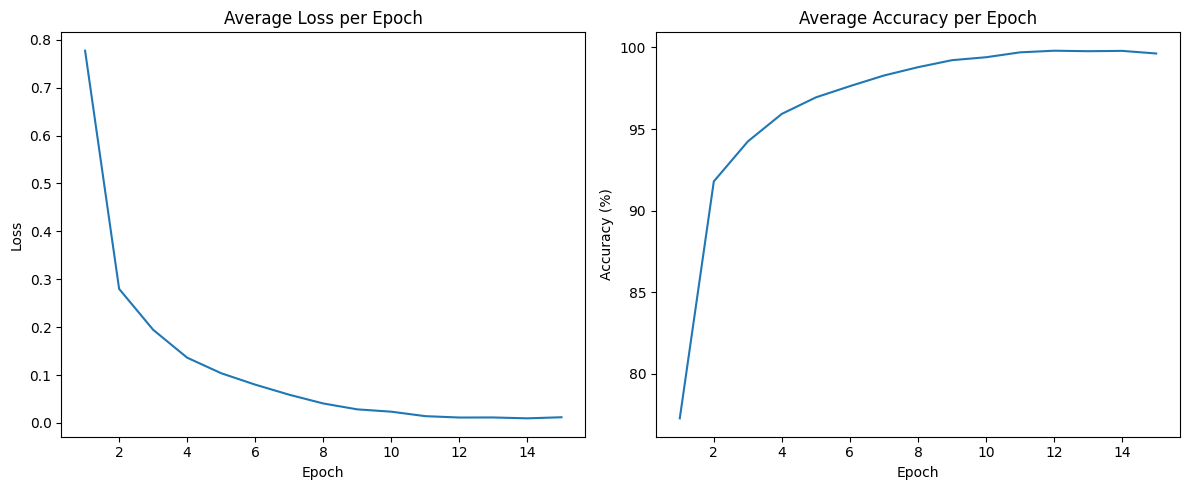

Model 1 parameters: tensor([-1.3569e-38, -5.5225e-39, -1.3291e-38, -1.1174e-38, -4.1390e-39,
         1.1938e-39, -3.7925e-39, -9.2675e-38,  2.2143e-39, -1.3234e-39],
       grad_fn=<SliceBackward0>)... (total: 567434)


In [100]:
# Hyperparameters
LEARNING_RATE = 0.0005
WEIGHT_DECAY = 1e-4
MAX_EPOCHS = 15
BATCH_SIZE = 64
UPDATE_INTERVAL = 500

# Initialize model
model = NeuralNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Count parameters
param_count = sum(p.numel() for p in model.parameters())
print(f'Total parameters in model: {param_count}')

# Train model
train_losses, train_accuracies, avg_losses, avg_accuracies = train_model(model, MAX_EPOCHS, BATCH_SIZE, UPDATE_INTERVAL)

# Create test loader
test_loader = create_data_loader(mnist_test, BATCH_SIZE, shuffle=False)

# Evaluate model
test_accuracy, test_loss = test_model(model, criterion, test_loader)

# Visualize training results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, MAX_EPOCHS + 1), avg_losses)
plt.title('Average Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, MAX_EPOCHS + 1), avg_accuracies)
plt.title('Average Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

# Save model parameters
model1_params = torch.nn.utils.parameters_to_vector(model.parameters())
print(f"Model 1 parameters: {model1_params[:10]}... (total: {len(model1_params)})")


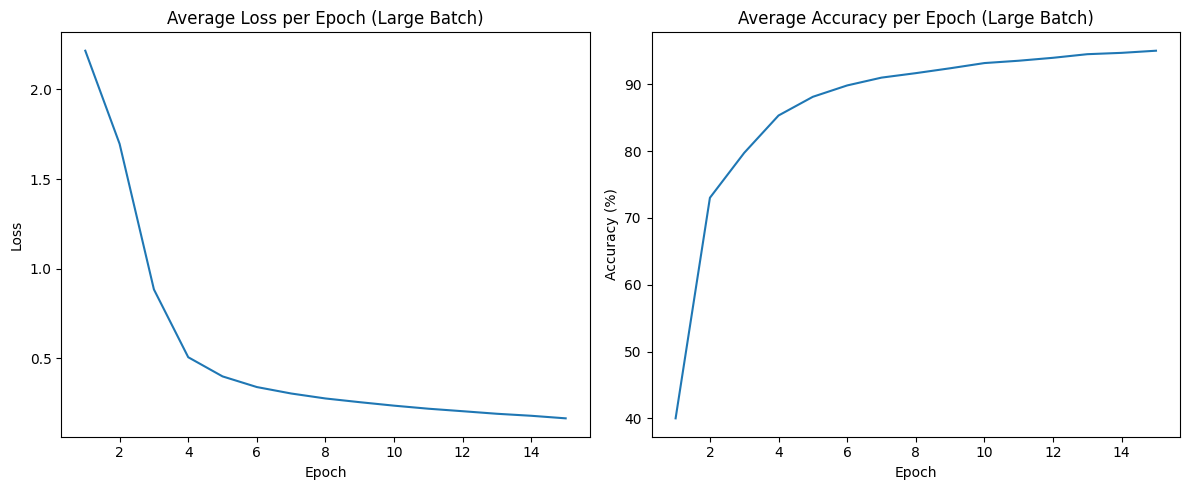

Model 2 parameters: tensor([ 8.9184e-06,  3.1560e-06, -5.4078e-06,  1.2782e-06, -5.0924e-05,
        -6.7906e-06,  1.5929e-05, -7.2060e-06, -2.7727e-07, -1.3273e-06],
       grad_fn=<SliceBackward0>)... (total: 567434)


In [101]:
# Train with larger batch size
LARGE_BATCH_SIZE = 1024
UPDATE_INTERVAL_LARGE = 5

model_large_batch = NeuralNet()
optimizer = torch.optim.Adam(model_large_batch.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

train_losses_large, train_accuracies_large, avg_losses_large, avg_accuracies_large = train_model(
    model_large_batch, MAX_EPOCHS, LARGE_BATCH_SIZE, UPDATE_INTERVAL_LARGE)

# Visualize training results for large batch size
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, MAX_EPOCHS + 1), avg_losses_large)
plt.title('Average Loss per Epoch (Large Batch)')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, MAX_EPOCHS + 1), avg_accuracies_large)
plt.title('Average Accuracy per Epoch (Large Batch)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.savefig(PROJECT_PATH + 'large_batch.png')
plt.show()

# Save large batch model parameters
model2_params = torch.nn.utils.parameters_to_vector(model_large_batch.parameters())
print(f"Model 2 parameters: {model2_params[:10]}... (total: {len(model2_params)})")

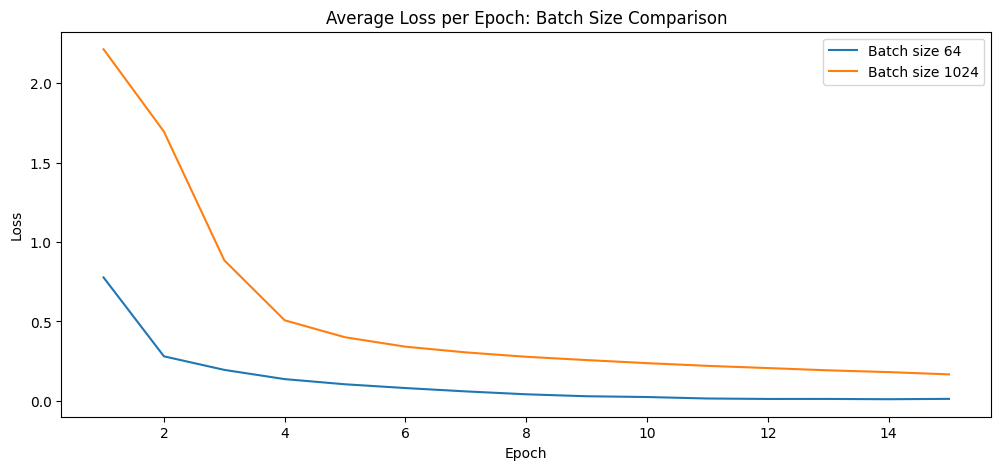

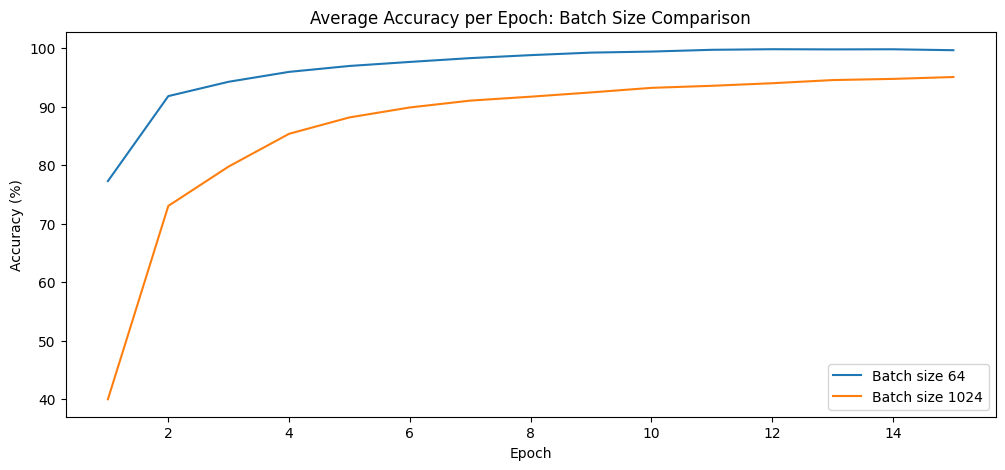

In [102]:
# Compare training curves - Loss
plt.figure(figsize=(12, 5))
plt.plot(range(1, len(avg_losses) + 1), avg_losses, label='Batch size 64')
plt.plot(range(1, len(avg_losses_large) + 1), avg_losses_large, label='Batch size 1024')
plt.title('Average Loss per Epoch: Batch Size Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(PROJECT_PATH + 'loss_comparison.png')
plt.show()

# Compare training curves - Accuracy
plt.figure(figsize=(12, 5))
plt.plot(range(1, len(avg_accuracies) + 1), avg_accuracies, label='Batch size 64')
plt.plot(range(1, len(avg_accuracies_large) + 1), avg_accuracies_large, label='Batch size 1024')
plt.title('Average Accuracy per Epoch: Batch Size Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.savefig(PROJECT_PATH + 'accuracy_comparison.png')
plt.show()

C:\Users\elrod\AppData\Local\Temp\ipykernel_5300\3089970650.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model1_params = torch.tensor(model1_params)
C:\Users\elrod\AppData\Local\Temp\ipykernel_5300\3089970650.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model2_params = torch.tensor(model2_params)


Evaluating interpolated model 1/31
Testing Accuracy: 96.55% 
Testing Loss: 2.9560
Evaluating interpolated model 2/31
Testing Accuracy: 96.74% 
Testing Loss: 2.3125
Evaluating interpolated model 3/31
Testing Accuracy: 96.88% 
Testing Loss: 1.7790
Evaluating interpolated model 4/31
Testing Accuracy: 97.10% 
Testing Loss: 1.3444
Evaluating interpolated model 5/31
Testing Accuracy: 97.32% 
Testing Loss: 0.9960
Evaluating interpolated model 6/31
Testing Accuracy: 97.51% 
Testing Loss: 0.7214
Evaluating interpolated model 7/31
Testing Accuracy: 97.77% 
Testing Loss: 0.5076
Evaluating interpolated model 8/31
Testing Accuracy: 97.95% 
Testing Loss: 0.3467
Evaluating interpolated model 9/31
Testing Accuracy: 98.27% 
Testing Loss: 0.2289
Evaluating interpolated model 10/31
Testing Accuracy: 98.50% 
Testing Loss: 0.1447
Evaluating interpolated model 11/31
Testing Accuracy: 98.73% 
Testing Loss: 0.0864
Evaluating interpolated model 12/31
Testing Accuracy: 99.02% 
Testing Loss: 0.0485
Evaluating in

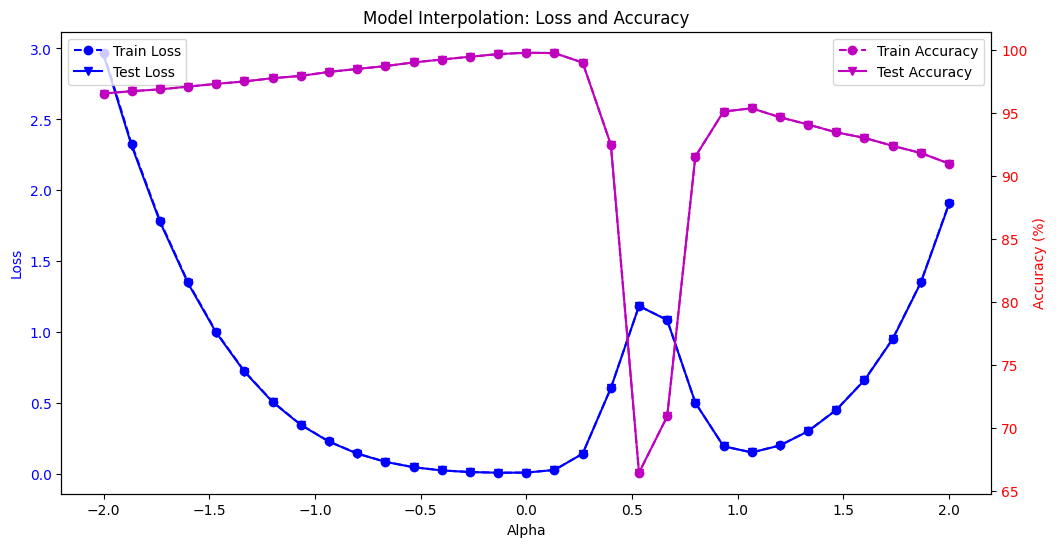

In [103]:
# Interpolation between models
alpha_values = torch.linspace(-2.0, 2.0, steps=31)
model1_params = torch.tensor(model1_params)
model2_params = torch.tensor(model2_params)
interpolated_models = []

for alpha in alpha_values:
    interpolated_params = (1 - alpha.item()) * model1_params + alpha.item() * model2_params
    interpolated_model = NeuralNet()
    torch.nn.utils.vector_to_parameters(interpolated_params, interpolated_model.parameters())
    interpolated_models.append(interpolated_model)

# Evaluate interpolated models
interpolated_train_losses = []
interpolated_train_accuracies = []
interpolated_test_losses = []
interpolated_test_accuracies = []

for i, model in enumerate(interpolated_models):
    print(f"Evaluating interpolated model {i+1}/{len(interpolated_models)}")
    
    # Quick training
    _, _, avg_loss, avg_acc = train_model(model, 1, 500, 100)
    interpolated_train_losses.append(avg_loss[0])
    interpolated_train_accuracies.append(avg_acc[0])
    
    # Testing
    test_acc, test_loss = test_model(model, criterion, test_loader)
    interpolated_test_losses.append(test_loss)
    interpolated_test_accuracies.append(test_acc)

# Visualize interpolation results
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(alpha_values.numpy(), interpolated_train_losses, 'b--o', label='Train Loss')
ax1.plot(alpha_values.numpy(), interpolated_test_losses, 'b-v', label='Test Loss')
ax1.set_xlabel('Alpha')
ax1.set_ylabel('Loss', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(alpha_values.numpy(), interpolated_train_accuracies, 'm--o', label='Train Accuracy')
ax2.plot(alpha_values.numpy(), interpolated_test_accuracies, 'm-v', label='Test Accuracy')
ax2.set_ylabel('Accuracy (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right')

plt.title('Model Interpolation: Loss and Accuracy')
plt.show()

#### Part-2

In [104]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
batch_sizes = [64, 176, 288, 400, 512]

In [105]:
def calculate_gradient_norm(model):
    total_norm = 0
    param_count = 0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
            param_count += 1
    return np.sqrt(total_norm) / param_count if param_count > 0 else 0

def should_early_stop(losses, threshold, patience):
    if len(losses) < patience + 1:
        return False
    recent_losses = losses[-patience:]
    if all(loss < threshold for loss in recent_losses):
        differences = [abs(losses[i] - losses[i-1]) for i in range(-patience+1, 0)]
        return all(diff < 1e-5 for diff in differences)
    return False

In [106]:
def train_model(model, criterion, optimizer, train_loader, num_epochs, train_batch_size, early_stop_threshold=0.001, early_stop_patience=3):
    model.train()
    n_total_steps = len(train_loader)
    train_losses, train_epochs, train_accuracies, sensitivities = [], [], [], []
    
    for epoch in range(1, num_epochs + 1):
        n_correct, n_samples, loss_sum = 0, 0, 0
        
        for i, (images, labels) in enumerate(train_loader, 1):
            images, labels = Variable(images), Variable(labels)
            images.requires_grad = True
            
            optimizer.zero_grad()
            predictions = model(images)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            
            # Calculate gradient norm
            grad_norm = calculate_gradient_norm(model)
            sensitivities.append(grad_norm)
            
            # Update metrics
            _, predicted = torch.max(predictions.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            loss_sum += loss.item()
            
            # Logging
            if i % 10 == 0:
                print(f'Epoch [{epoch}/{num_epochs}], Step [{i}/{n_total_steps}], Loss: {loss.item():.4f}', end='\r', flush=True)
        
        # Epoch summary
        epoch_loss = loss_sum / n_total_steps
        epoch_accuracy = 100.0 * n_correct / n_samples
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        train_epochs.append(epoch)
        
        print(f"\nEpoch {epoch} - Avg Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
        
        # Early stopping check
        if should_early_stop(train_losses, early_stop_threshold, early_stop_patience):
            print(f"Early stopping at epoch {epoch}")
            break
    
    return train_epochs, train_losses, train_accuracies, sensitivities, epoch_loss

def test_model(model, criterion, test_loader):
    model.eval()
    n_correct, n_samples, test_loss = 0, 0, 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = Variable(images), Variable(labels)
            predictions = model(images)
            test_loss += criterion(predictions, labels).item()
            
            _, predicted = torch.max(predictions.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
    
    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100.0 * n_correct / n_samples
    print(f'Test Accuracy: {test_accuracy:.2f}%, Test Loss: {avg_test_loss:.4f}')
    
    return test_accuracy, avg_test_loss

In [107]:
def train_and_evaluate_models(Model, batch_sizes, max_epochs=5, learning_rate=1e-3, weight_decay=1e-4):
    results = {
        'train_epochs': [],
        'train_losses': [],
        'train_accuracies': [],
        'test_accuracies': [],
        'test_losses': [],
        'sensitivities': []
    }

    base_model = Model()
    total_params = sum(p.numel() for p in base_model.parameters())
    print(f'Total number of parameters in Model: {total_params}')

    for batch_size in batch_sizes:
        model = copy.deepcopy(base_model)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

        # Train the model
        train_epochs, train_losses, train_accuracies, sensitivities, avg_loss = train_model(
            model, criterion, optimizer, train_loader, max_epochs, batch_size
        )

        # Test the model
        test_accuracy, test_loss = test_model(model, criterion, test_loader)

        # Store results
        results['train_epochs'].append(train_epochs)
        results['train_losses'].append(train_losses)
        results['train_accuracies'].append(train_accuracies)
        results['test_accuracies'].append(test_accuracy)
        results['test_losses'].append(test_loss)
        results['sensitivities'].append(sensitivities)

        print(f"Batch size {batch_size}: Test Accuracy = {test_accuracy:.2f}%, Test Loss = {test_loss:.4f}")

    return results

results = train_and_evaluate_models(Model, batch_sizes)

Total number of parameters in Model: 567434
Epoch [1/5], Step [100/100], Loss: 0.2363
Epoch 1 - Avg Loss: 0.5794, Accuracy: 84.09%
Epoch [2/5], Step [100/100], Loss: 0.2302
Epoch 2 - Avg Loss: 0.1951, Accuracy: 94.33%
Epoch [3/5], Step [100/100], Loss: 0.1352
Epoch 3 - Avg Loss: 0.1332, Accuracy: 96.10%
Epoch [4/5], Step [100/100], Loss: 0.0647
Epoch 4 - Avg Loss: 0.0961, Accuracy: 97.12%
Epoch [5/5], Step [100/100], Loss: 0.0519
Epoch 5 - Avg Loss: 0.0738, Accuracy: 97.81%
Test Accuracy: 97.08%, Test Loss: 0.0910
Batch size 64: Test Accuracy = 97.08%, Test Loss = 0.0910
Epoch [1/5], Step [100/100], Loss: 0.2470
Epoch 1 - Avg Loss: 0.5822, Accuracy: 83.91%
Epoch [2/5], Step [100/100], Loss: 0.1578
Epoch 2 - Avg Loss: 0.1933, Accuracy: 94.42%
Epoch [3/5], Step [100/100], Loss: 0.1134
Epoch 3 - Avg Loss: 0.1296, Accuracy: 96.13%
Epoch [4/5], Step [100/100], Loss: 0.1364
Epoch 4 - Avg Loss: 0.0975, Accuracy: 97.11%
Epoch [5/5], Step [100/100], Loss: 0.0578
Epoch 5 - Avg Loss: 0.0750, Accu

In [108]:
def calculate_statistic(data_arr, statistic_func):
    return [statistic_func(data) for data in data_arr]

def plot_metrics(batch_sizes, train_metric, test_metric, sensitivity, metric_name, output_path):
    _, ax1 = plt.subplots(figsize=(10, 6))
    
    # Plot train and test metrics
    ax1.plot(batch_sizes, train_metric, color="blue", marker="o", linestyle='dashed', label=f'Train {metric_name}')
    ax1.plot(batch_sizes, test_metric, color="blue", marker="v", label=f'Test {metric_name}')
    ax1.set_xlabel("Batch Size", color="black")
    ax1.set_ylabel(metric_name, color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")
    ax1.legend(loc="upper left")

    # Plot sensitivity on secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(batch_sizes, sensitivity, color="red", label='Sensitivity')
    ax2.set_ylabel("Sensitivity", color="red")
    ax2.tick_params(axis='y', labelcolor="red")
    ax2.legend(loc="upper right")

    plt.title(f"{metric_name} and Sensitivity vs Batch Size", color="black")
    plt.tight_layout()
    plt.savefig(output_path, format='png', dpi=100, bbox_inches='tight')
    plt.show()

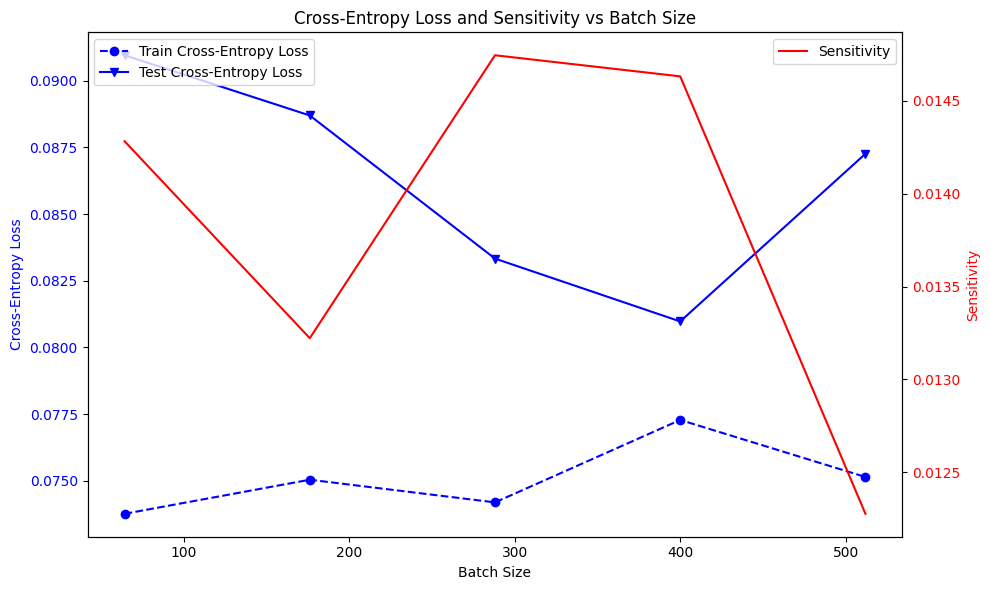

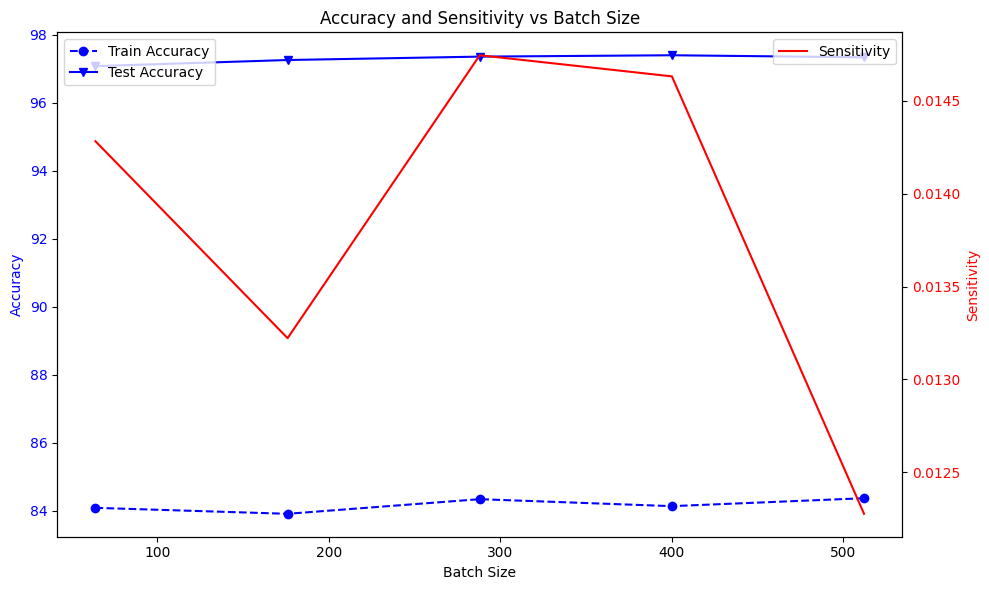

In [109]:
# Calculate statistics
train_loss_min = calculate_statistic(results['train_losses'], np.min)
test_loss = results['test_losses']
train_acc_min = calculate_statistic(results['train_accuracies'], np.min)
test_acc = results['test_accuracies']
sensitivity_min = calculate_statistic(results['sensitivities'], np.min)

# Plot Loss
plot_metrics(
    batch_sizes,
    train_loss_min,
    test_loss,
    sensitivity_min,
    "Cross-Entropy Loss",
    PROJECT_PATH + 'loss_sensitivity.png'
)

# Plot Accuracy
plot_metrics(
    batch_sizes,
    train_acc_min,
    test_acc,
    sensitivity_min,
    "Accuracy",
    PROJECT_PATH + 'accuracy_sensitivity.png'
)